In [1]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
# Mount GDRIVE jika menggunakan Google Collab
# from google.colab import drive
# drive.mount('/content/drive')

# PATH = '/content/drive/MyDrive/'

# Jika tidak menggunakan google collab
PATH = ''

## Load Data

In [3]:
dataset_path = PATH + 'Indonesian Herb Leaf Dataset 3500/'

image_path = []
label      = []
for x, i in enumerate(os.listdir(dataset_path)):
    new_data_path = dataset_path + str(i)
    for filename in os.listdir(new_data_path):
        source_path = os.path.join(new_data_path, filename)
        image_path.append(source_path)
        label.append(new_data_path.split('/')[-1])

In [4]:
df = pd.DataFrame({'image_path': image_path,
                   'label': label
                  })
df

,image_path,label
0,Indonesian Herb Leaf Dataset 3500/Belimbing Wu...,Belimbing Wuluh
1,Indonesian Herb Leaf Dataset 3500/Belimbing Wu...,Belimbing Wuluh
2,Indonesian Herb Leaf Dataset 3500/Belimbing Wu...,Belimbing Wuluh
3,Indonesian Herb Leaf Dataset 3500/Belimbing Wu...,Belimbing Wuluh
4,Indonesian Herb Leaf Dataset 3500/Belimbing Wu...,Belimbing Wuluh
...,...,...
3495,Indonesian Herb Leaf Dataset 3500/Sirih\Sirih3...,Sirih
3496,Indonesian Herb Leaf Dataset 3500/Sirih\Sirih3...,Sirih
3497,Indonesian Herb Leaf Dataset 3500/Sirih\Sirih3...,Sirih
3498,Indonesian Herb Leaf Dataset 3500/Sirih\Sirih3...,Sirih


**Total data pada setiap kelas.**

In [5]:
df.label.value_counts()

label
Belimbing Wuluh    350
Jambu Biji         350
Jeruk Nipis        350
Kemangi            350
Lidah Buaya        350
Nangka             350
Pandan             350
Pepaya             350
Seledri            350
Sirih              350
Name: count, dtype: int64

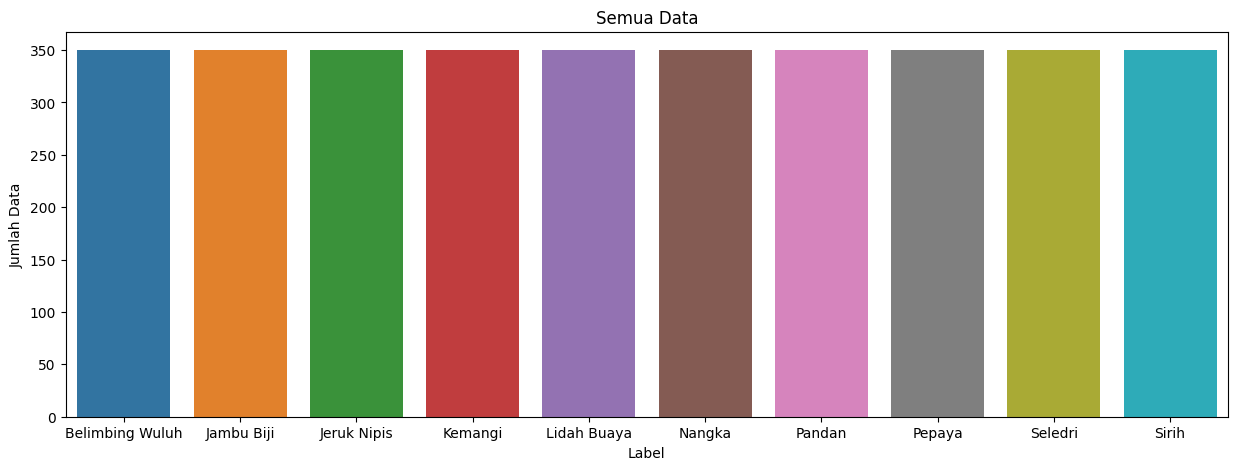

In [6]:
plt.figure(figsize=(15, 5))
plt.title('Semua Data')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
sns.countplot(data=df, x='label', hue='label');

**Contoh data sebelum augmentasi**

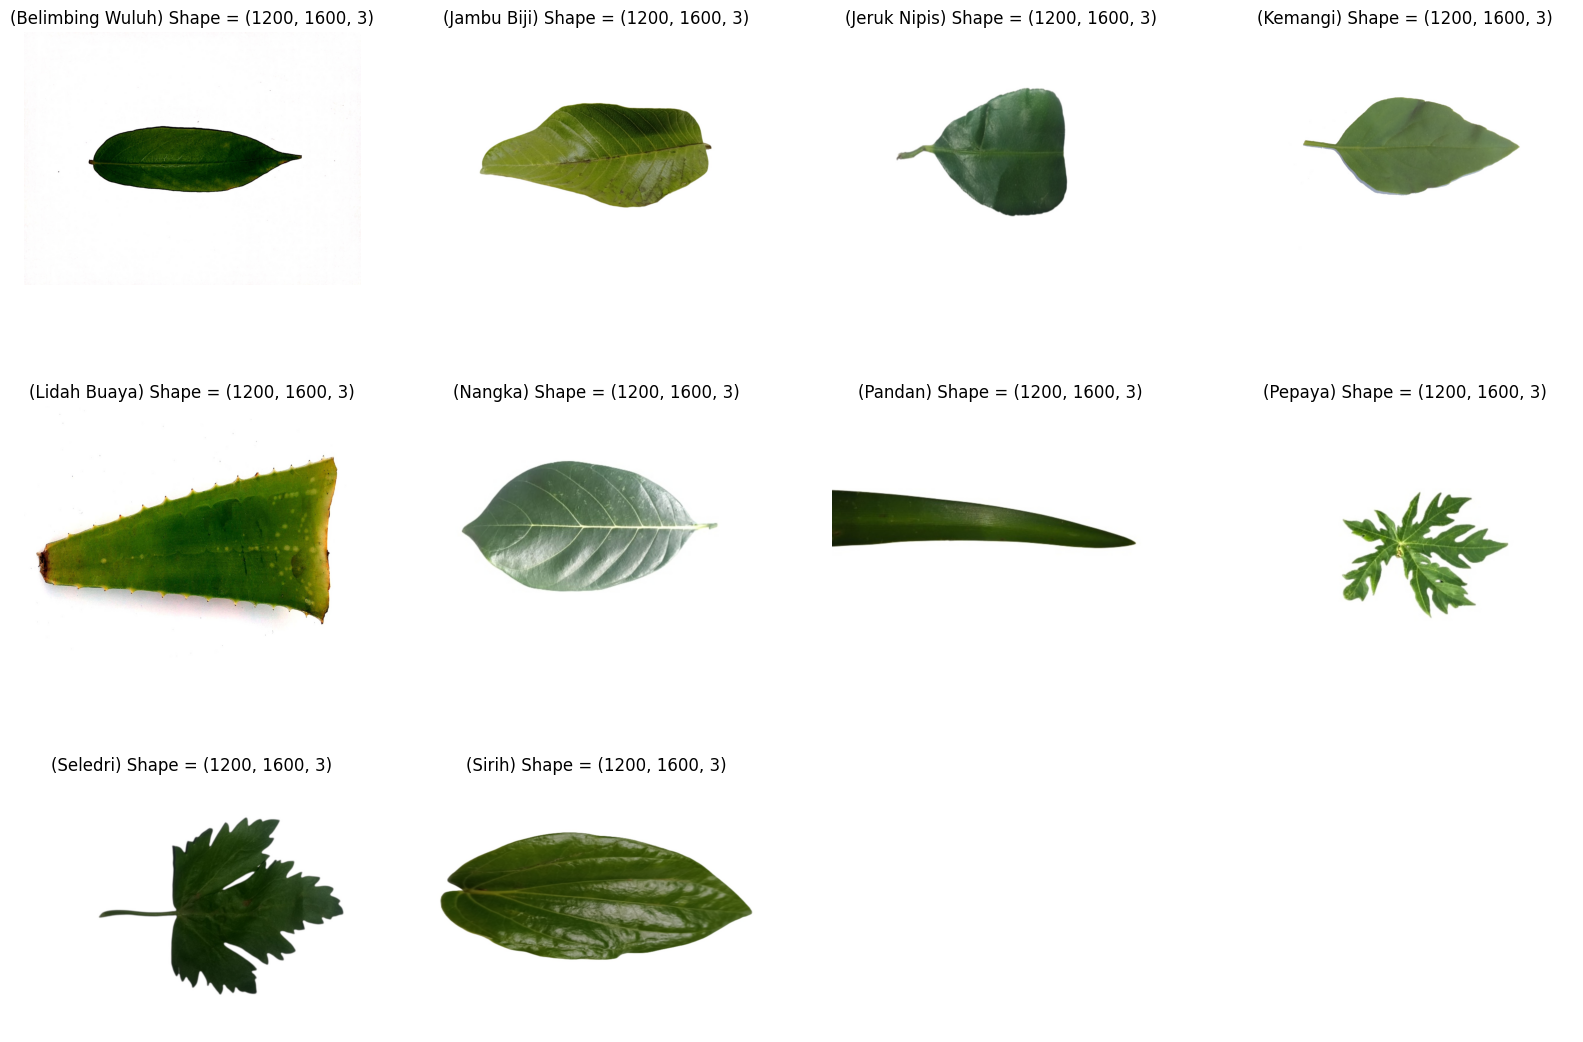

In [25]:
classes = sorted(os.listdir(dataset_path))  # Mengurutkan nama folder
plt.figure(figsize=(20,38))
for i, class_name in enumerate(classes):
    image_path = os.path.join(dataset_path, class_name)
    image_file = os.listdir(image_path)[0]
    image = plt.imread(os.path.join(image_path, image_file))
    image = np.asarray(image)
    plt.subplot(8, 4, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('({0}) Shape = {1}'.format(class_name, image.shape))
plt.show()


## Augmentasi Data

Menerapkan teknik augmentasi data untuk meningkatkan variasi dataset.

1. Brightness (tingkat kecerahan dalam rentang antara 0 (sangat gelap) hingga 2 (sangat terang))
2. Rotation (gambar akan diputar secara acak hingga sudut maksimum ±180 derajat)
3. Vertical Flip (gambar akan dibalik secara vertikal)

In [8]:
classes = df['label'].unique()
classes

array(['Belimbing Wuluh', 'Jambu Biji', 'Jeruk Nipis', 'Kemangi',
       'Lidah Buaya', 'Nangka', 'Pandan', 'Pepaya', 'Seledri', 'Sirih'],
      dtype=object)

Referensi implementasi augmentasi: https://medium.com/analytics-vidhya/understanding-image-augmentation-using-keras-tensorflow-a6341669d9ca

In [9]:
maximum_total_data = 500 # Set maximum dari (original data + augmented data)

# Tentukan TensorFlow ImageDataGenerators dengan pengaturan augmentasi terpisah
brightness_datagen    = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range=[0,2])
rotation_datagen      = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=180)
vertical_flip_datagen = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True)

**Contoh data setelah augmentasi**

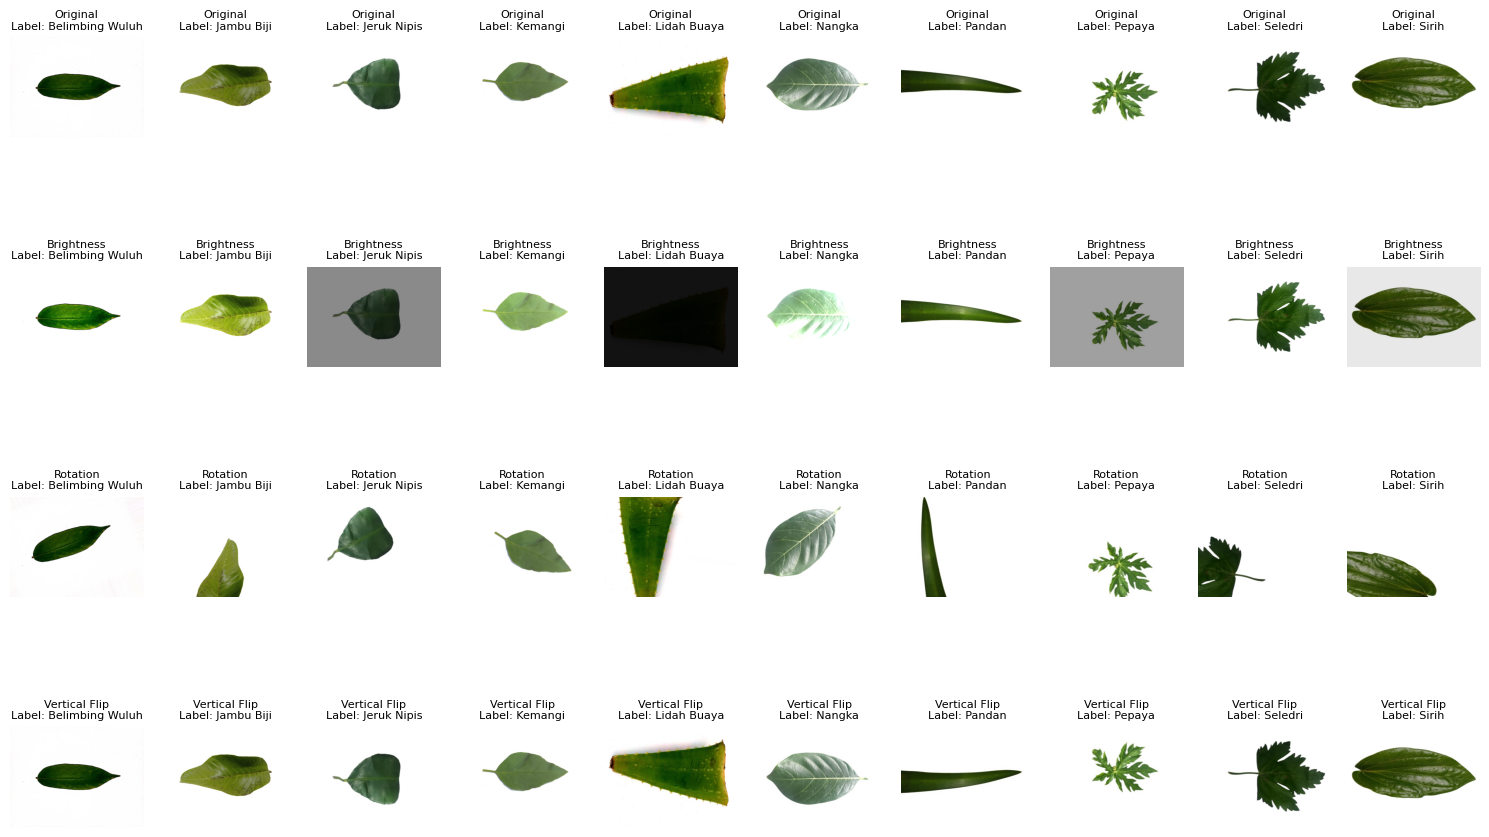

In [24]:
fig, axes = plt.subplots(nrows=4, ncols=len(df['label'].unique()), figsize=(15, 10))

for i, (label, group) in enumerate(df.groupby('label')):
    # Read and process the image
    img = cv2.imread(group['image_path'].iloc[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.clip(img, 0, 255).astype(np.uint8)

    # Original
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Original\nLabel: {label}', fontsize=8)
    axes[0, i].axis('off')

    # Brightness
    img_brightness = brightness_datagen.random_transform(img)
    img_brightness = np.clip(img_brightness, 0, 255).astype(np.uint8)
    axes[1, i].imshow(img_brightness)
    axes[1, i].set_title(f'Brightness\nLabel: {label}', fontsize=8)
    axes[1, i].axis('off')

    # Rotation
    img_rotated = rotation_datagen.random_transform(img)
    img_rotated = np.clip(img_rotated, 0, 255).astype(np.uint8)
    axes[2, i].imshow(img_rotated)
    axes[2, i].set_title(f'Rotation\nLabel: {label}', fontsize=8)
    axes[2, i].axis('off')

    # Vertical Flip
    img_vertical_flipped = vertical_flip_datagen.random_transform(img)
    img_vertical_flipped = np.clip(img_vertical_flipped, 0, 255).astype(np.uint8)
    axes[3, i].imshow(img_vertical_flipped)
    axes[3, i].set_title(f'Vertical Flip\nLabel: {label}', fontsize=8)
    axes[3, i].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


In [10]:
augmented_path = 'augmented_images'
if not os.path.exists(augmented_path):
    os.makedirs(augmented_path)
    
list_augmented_image = []

for cl in classes:
    print(f"Augmentasi untuk kelas: {cl}")
    
    # Cek apakah folder sudah ada atau belum
    augmented_class_path = os.path.join(augmented_path, cl)
    if os.path.exists(augmented_class_path):
        shutil.rmtree(augmented_class_path)

    os.makedirs(augmented_class_path)
    
    total_original_class_data = df.label.value_counts().get(cl, 0)
    
    selected_data = df[df['label'] == cl].sample(frac=1) # shuffle 

    # Proses augmentasi setiap data pada file
    tmp_list_augmented_image = []
    
    for index, row in selected_data.iterrows():
        if len(tmp_list_augmented_image) + total_original_class_data >= maximum_total_data:
            break
        # random_number = random.randint(0, 1)
        file_name = row['image_path'].split(os.sep)[-1]
        label = row['label']

        # Read Image
        img = cv2.imread(row['image_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 1. Brightness
        img_brightness = brightness_datagen.random_transform(img)
        file_brightness = os.path.join(augmented_class_path, f'brightness_{file_name}')
        cv2.imwrite(file_brightness, cv2.cvtColor(img_brightness, cv2.COLOR_RGB2BGR))
        tmp_list_augmented_image.append({'image_path': file_brightness, 'label':label})
        
        # 2. Rotation
        img_rotated  = rotation_datagen.random_transform(img)
        file_rotated = os.path.join(augmented_class_path, f'rotated_{file_name}')
        cv2.imwrite(file_rotated, cv2.cvtColor(img_rotated, cv2.COLOR_RGB2BGR))
        tmp_list_augmented_image.append({'image_path': file_rotated, 'label':label})

        # 3. Flip
        img_flipped = vertical_flip_datagen.random_transform(img)
        file_flipped = os.path.join(augmented_class_path, f'fliped_{file_name}')
        cv2.imwrite(file_flipped, cv2.cvtColor(img_flipped, cv2.COLOR_RGB2BGR))
        tmp_list_augmented_image.append({'image_path': file_flipped, 'label':label})

    list_augmented_image = list_augmented_image + tmp_list_augmented_image
    print(f"Augmentasi selesai untuk kelas: {cl}")
    
print("Proses augmentasi selesai untuk semua kelas.")

Augmentasi untuk kelas: Belimbing Wuluh
Augmentasi selesai untuk kelas: Belimbing Wuluh
Augmentasi untuk kelas: Jambu Biji
Augmentasi selesai untuk kelas: Jambu Biji
Augmentasi untuk kelas: Jeruk Nipis
Augmentasi selesai untuk kelas: Jeruk Nipis
Augmentasi untuk kelas: Kemangi
Augmentasi selesai untuk kelas: Kemangi
Augmentasi untuk kelas: Lidah Buaya
Augmentasi selesai untuk kelas: Lidah Buaya
Augmentasi untuk kelas: Nangka
Augmentasi selesai untuk kelas: Nangka
Augmentasi untuk kelas: Pandan
Augmentasi selesai untuk kelas: Pandan
Augmentasi untuk kelas: Pepaya
Augmentasi selesai untuk kelas: Pepaya
Augmentasi untuk kelas: Seledri
Augmentasi selesai untuk kelas: Seledri
Augmentasi untuk kelas: Sirih
Augmentasi selesai untuk kelas: Sirih
Proses augmentasi selesai untuk semua kelas.


In [11]:
df_augmented = pd.DataFrame(list_augmented_image)
df_augmented

,image_path,label
0,augmented_images\Belimbing Wuluh\brightness_Be...,Belimbing Wuluh
1,augmented_images\Belimbing Wuluh\rotated_Belim...,Belimbing Wuluh
2,augmented_images\Belimbing Wuluh\fliped_Belimb...,Belimbing Wuluh
3,augmented_images\Belimbing Wuluh\brightness_Be...,Belimbing Wuluh
4,augmented_images\Belimbing Wuluh\rotated_Belim...,Belimbing Wuluh
...,...,...
1495,augmented_images\Sirih\rotated_Sirih160.jpg,Sirih
1496,augmented_images\Sirih\fliped_Sirih160.jpg,Sirih
1497,augmented_images\Sirih\brightness_Sirih277.jpg,Sirih
1498,augmented_images\Sirih\rotated_Sirih277.jpg,Sirih


#### Gabungkan original data dan augmented data

Setelah kita augmentasi data maka akan di lanjutkan untuk di gabungkan original data dan augmented data sehingga akan menjadi 1 data keseluruhan

In [15]:
df_all_data = pd.concat([df, df_augmented], ignore_index=True)
df_all_data

,image_path,label
0,Indonesian Herb Leaf Dataset 3500/Belimbing Wu...,Belimbing Wuluh
1,Indonesian Herb Leaf Dataset 3500/Belimbing Wu...,Belimbing Wuluh
2,Indonesian Herb Leaf Dataset 3500/Belimbing Wu...,Belimbing Wuluh
3,Indonesian Herb Leaf Dataset 3500/Belimbing Wu...,Belimbing Wuluh
4,Indonesian Herb Leaf Dataset 3500/Belimbing Wu...,Belimbing Wuluh
...,...,...
4995,augmented_images\Sirih\rotated_Sirih160.jpg,Sirih
4996,augmented_images\Sirih\fliped_Sirih160.jpg,Sirih
4997,augmented_images\Sirih\brightness_Sirih277.jpg,Sirih
4998,augmented_images\Sirih\rotated_Sirih277.jpg,Sirih


**Jumlah data setelah augmentasi**

In [26]:
df_all_data.label.value_counts()

label
Belimbing Wuluh    500
Jambu Biji         500
Jeruk Nipis        500
Kemangi            500
Lidah Buaya        500
Nangka             500
Pandan             500
Pepaya             500
Seledri            500
Sirih              500
Name: count, dtype: int64

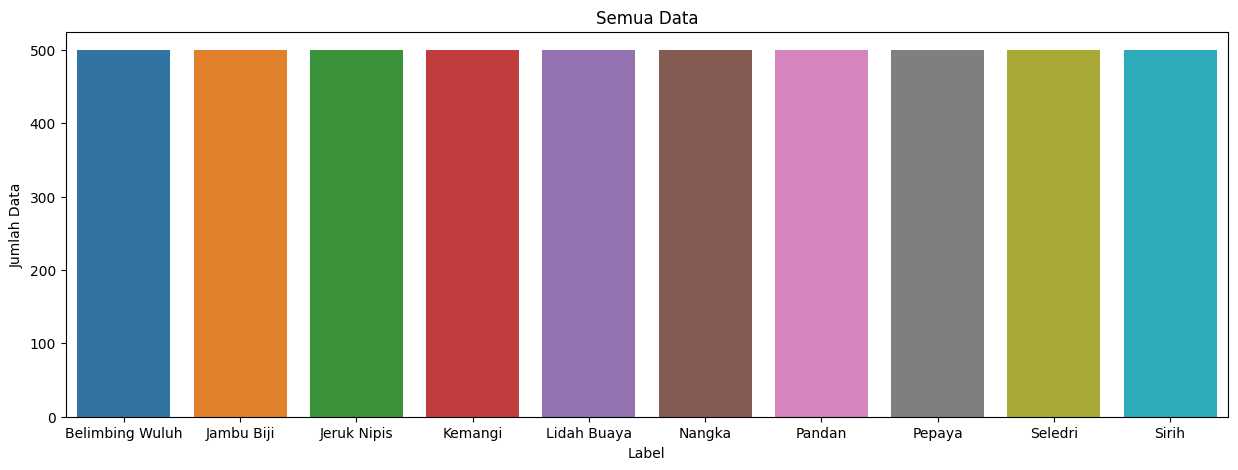

In [27]:
plt.figure(figsize=(15, 5))
plt.title('Semua Data')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
sns.countplot(data=df_all_data, x='label', hue='label');

## Split Data

Proses split data ini akan membagi data menjadi Training, Testing, & Validation. 80% train data, 10% validation data, dan 10% test data.
Untuk split nya sendiri akan di bagi menggunakan proses:
- Train 80% dan Test 20%
- Validation ambil data dari Test di mana data Test dibagi 2 menjadi Test 10% dan validation 10%

In [28]:
train_df, test_df = train_test_split(df_all_data, test_size=0.2, random_state=42)
test_df, val_df   = train_test_split(test_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print('Total data training :',  train_df.shape[0])
print('Total data validasi :',  val_df.shape[0])
print('Total data testing  :',  test_df.shape[0])

Total data training : 4000
Total data validasi : 500
Total data testing  : 500


**Jumlah Data pada setiap Class Training**

In [29]:
train_df.label.value_counts()

label
Nangka             427
Lidah Buaya        406
Pandan             406
Sirih              404
Kemangi            402
Pepaya             396
Jeruk Nipis        393
Seledri            392
Jambu Biji         387
Belimbing Wuluh    387
Name: count, dtype: int64

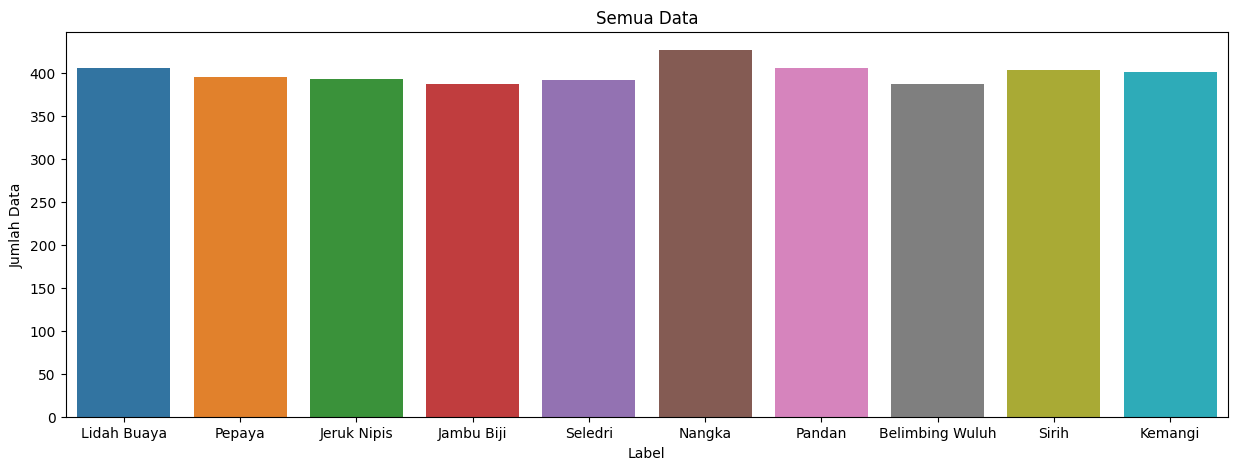

In [30]:
plt.figure(figsize=(15, 5))
plt.title('Semua Data')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
sns.countplot(data=train_df, x='label', hue='label');

**Jumlah Data pada setiap class Validasi**

In [31]:
val_df.label.value_counts()

label
Jambu Biji         61
Belimbing Wuluh    58
Jeruk Nipis        57
Seledri            57
Pepaya             55
Pandan             47
Kemangi            45
Lidah Buaya        43
Sirih              42
Nangka             35
Name: count, dtype: int64

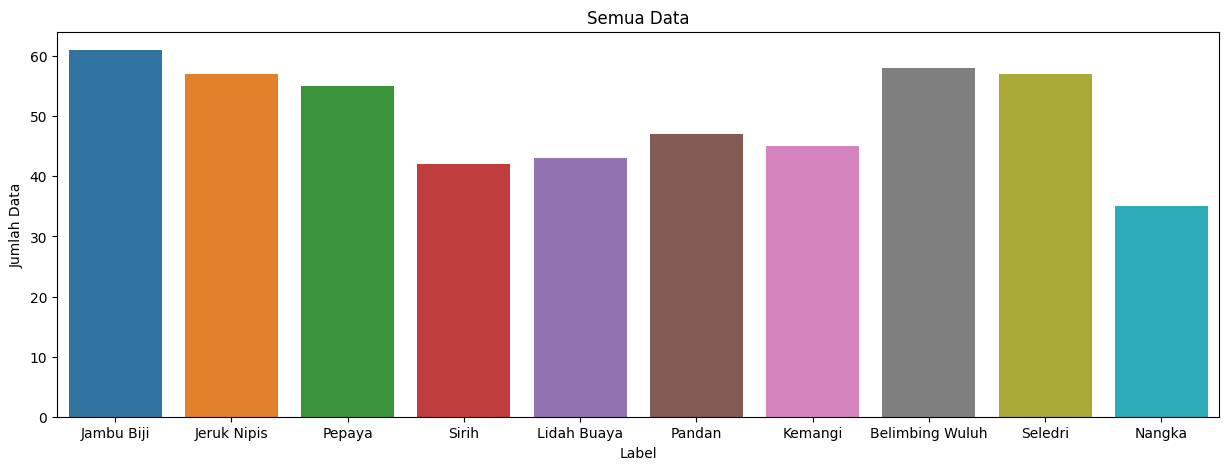

In [32]:
plt.figure(figsize=(15, 5))
plt.title('Semua Data')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
sns.countplot(data=val_df, x='label', hue='label');

**Jumlah Data pada setiap class Testing**

In [37]:
test_df.label.value_counts()

label
Belimbing Wuluh    55
Sirih              54
Kemangi            53
Jambu Biji         52
Seledri            51
Lidah Buaya        51
Jeruk Nipis        50
Pepaya             49
Pandan             47
Nangka             38
Name: count, dtype: int64

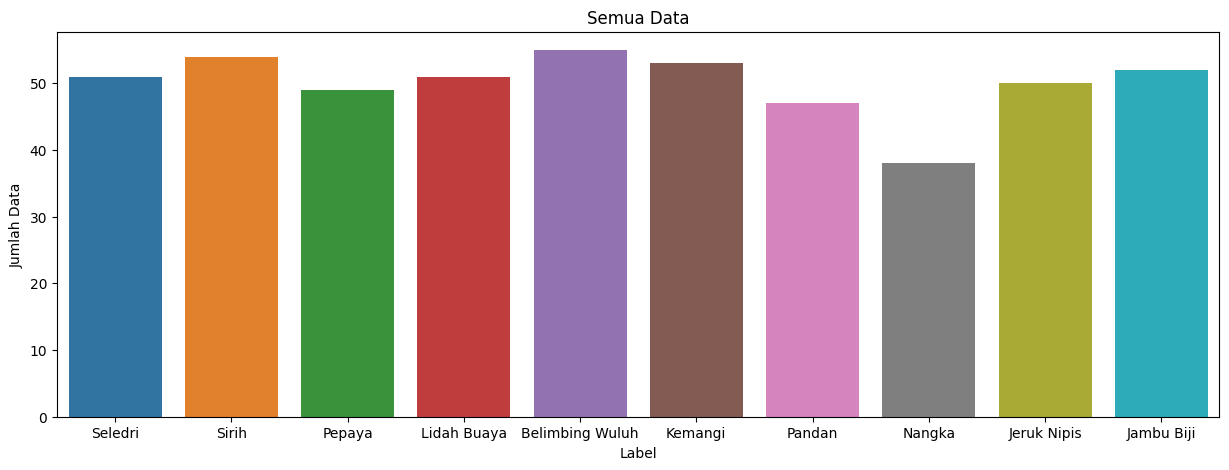

In [38]:
plt.figure(figsize=(15, 5))
plt.title('Semua Data')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
sns.countplot(data=test_df, x='label', hue='label');

## Export datasets to csv

In [36]:
train_csv_path = os.path.join(PATH, 'train.csv')
train_df.to_csv(train_csv_path, index=False)

validatoin_csv_path = os.path.join(PATH, 'validation.csv')
val_df.to_csv(validatoin_csv_path, index=False)

test_csv_path = os.path.join(PATH, 'test.csv')
test_df.to_csv(test_csv_path, index=False)